In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True, linewidth=120)

,time,ind_fact,ind_x,seg_fact_0,seg_x_0,seg_fact_1,seg_x_1,seg_fact_2,seg_x_2,seg_fact_3,...,y_14_5,y_14_6,y_14_7,y_14_8,y_14_9,y_14_10,y_14_11,y_14_12,y_14_13,y_14_14
0,2006-01-01,0.617965,0.654700,0.517785,0.200695,-0.999200,0.259699,-1.417194,0.320737,-3.131246,...,1.385803,4.620832,-0.193936,-2.666683,0.526839,0.423255,1.906371,-1.296323,-0.026990,2.015227
1,2006-02-01,0.834329,0.525347,-0.303949,-0.666398,-1.807114,-1.107674,0.378779,1.370814,-2.371504,...,0.958663,1.347085,1.903951,-0.055620,0.658546,1.306383,1.232520,1.283027,-0.566588,0.122759
2,2006-03-01,-0.619074,-1.036238,-1.258184,-1.045420,0.595070,1.860050,0.757052,0.491907,0.407830,...,-1.047597,1.539211,-0.635678,-1.376512,-0.548557,-3.372843,-2.065605,-0.945536,-2.751730,-1.283216
3,2006-04-01,-0.951931,-0.642394,-1.439187,-0.558457,1.510847,1.094298,-1.093307,-1.623244,0.226521,...,-0.207184,1.167364,2.431327,0.030806,2.022486,1.126419,-0.535156,1.405863,1.543787,0.789375
4,2006-05-01,-0.622445,-0.146479,0.117217,1.124647,0.432032,-0.625561,-1.566107,-0.800792,0.658889,...,-0.751306,1.495487,-0.076381,-2.715428,0.668863,-0.382194,-1.092149,-0.097468,0.333418,-0.916081


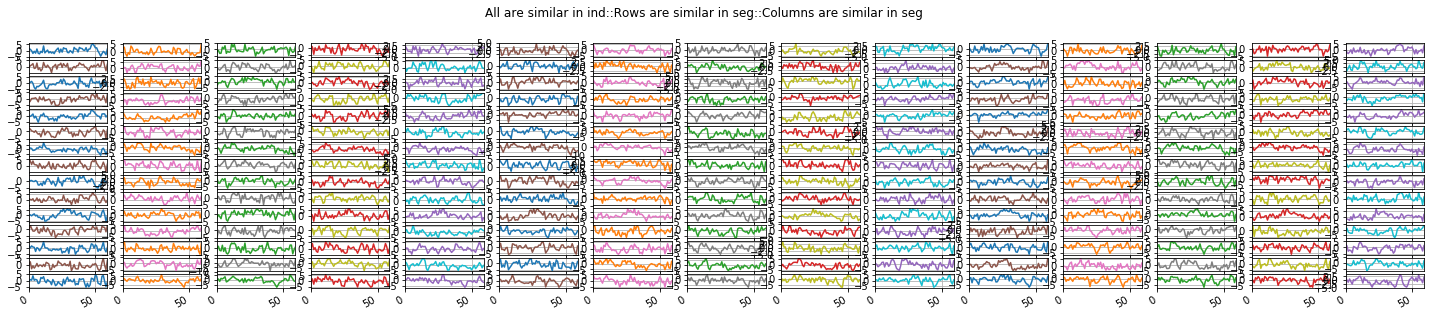

In [3]:
###simulate time series data 
periods=1000
seed=98165
# factor_model=pd.DataFrame(pd.date_range(start='1/1/2018', end='2/1/2019', freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

factor_model=pd.DataFrame(pd.date_range(start='1/1/2006', periods=periods, freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

np.random.seed(seed)

def factor_gen(size=periods, beta=0.8, burner=2, scale=1):
    j=burner+size
    x=np.random.normal(loc=0.0, scale=scale, size=j)
    
    y=[0]*j
    for i in range(j):
        
        if i==0:
            y0=0 
        else:
            y[i]=beta*y0 + x[i]
            y0=y[i]
            
    return y[-size:], x[-size:]

###industry factor
fact_name='ind_fact'
fact_name_x='ind_x'
fact, fact_x = factor_gen(size=periods, beta=0.5, burner=200)
factor_model[fact_name]=fact 
factor_model[fact_name_x]=fact_x 

###segment factor
seg=15
sub=15
for i in range(seg):
    fact_name='seg_fact_'+str(i)
    fact_name_x='seg_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.7, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 

###brand factor
for i in range(sub):
    fact_name='sub_fact_'+str(i)
    fact_name_x='sub_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.3, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 
    
###idiosyncratic factor
for s in range(seg):
    for b in range(sub):
        fact_name='idi_fact_' + str(s) + '_' + str(b)
        fact_name_x='idi_fact_x' + str(s) + '_' + str(b)
        fact, fact_x = factor_gen(size=periods, beta=0.4, burner=200, scale=1)
        factor_model[fact_name]=fact
        factor_model[fact_name_x]=fact_x

# factor_model['x1']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x2']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))  
# factor_model['x3']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x4']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x5']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x6']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x7']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x8']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x9']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x10']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))


        
###observed y --output

for s in range(seg):
    for b in range(sub):
        fact_name='y_' + str(s) + '_' + str(b)
        seg_fact='seg_fact_' + str(s)
        sub_fact='sub_fact_' + str(b)
        idi_fact= 'idi_fact_' + str(s) + '_' + str(b)
#         factor_model[fact_name]=factor_model['ind_fact']+factor_model[seg_fact] + factor_model[sub_fact] + factor_model[idi_fact]
        factor_model[fact_name]=factor_model['ind_fact'] + factor_model[seg_fact] + factor_model[sub_fact] + factor_model[idi_fact] 
#         factor_model[fact_name]=factor_model['ind_fact']  + factor_model[idi_fact] + 0.2*factor_model['x1'] -  0.2*factor_model['x2'] \
#         + 0.2*factor_model['x3'] -  0.2*factor_model['x4'] + 0.2*factor_model['x5'] -  0.2*factor_model['x6'] \
#         + 0.2*factor_model['x7'] -  0.2*factor_model['x8'] + 0.2*factor_model['x9'] -  0.2*factor_model['x10'] 
        factor_model[fact_name_x]=fact_x
    
# print(factor_model.columns)
_=factor_model[[name for name in factor_model.columns if 'y_' in name]][(
    factor_model.time.dt.year<=2010)].plot(subplots=True, layout=( seg,sub), figsize=(25, 5), grid=True, legend=False, 
                                           title='All are similar in ind::Rows are similar in seg::Columns are similar in seg')
factor_model.head(5)

In [4]:
# call existing package
var_list=[name for name in factor_model.columns if 'y_' in name]
endog=factor_model[var_list][0:500]
# exog=factor_model[['x1','x2']]
# [name for name in factor_model.columns if 'y_' in name]
import time

In [5]:
numl=[]
for char in var_list: #set the first column as ones for f_seg
    num = [int(i) for i in char.split('_') if i.isdigit()]
    numl.append(num)

seg_bnd=[ ['seg_'+str(numl[ivar][0]).zfill(3),'bnd_'+str(numl[ivar][1]).zfill(3)]  for ivar in range(len(var_list))]

factors={var_list[ivar] :  ['Global',seg_bnd[ivar][0], seg_bnd[ivar][1]] for ivar in range(len(var_list))}
# factors

In [6]:
# factors
factor_multiplicities={'Global': 1}

In [7]:
# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog=endog,
    factors=factors, factor_orders=1,
    factor_multiplicities=1,  idiosyncratic_ar1=True) # idiosyncratic_ar1=False which means NO AR(1) fitting. Error AR(1) is default So far no AR(2)+ are avaliable.

In [8]:
# model.summary()

In [9]:
ts=time.time()
results = model.fit(disp=10)
print(time.time()-ts)

EM start iterations, llf=-90599
EM iteration 10, llf=-84481, convergence criterion=1.1724e-06
EM converged at iteration 15, llf=-84481, convergence criterion=9.9664e-07 < tolerance=1e-06
72.97599482536316


In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Dynamic Factor Results                               
=====================================================================================
Dep. Variable:         "y_0_0", and 224 more   No. Observations:                  500
Model:                  Dynamic Factor Model   Log Likelihood              -84480.827
                   + 31 factors in 31 blocks   AIC                         171335.654
                       + AR(1) idiosyncratic   BIC                         176338.394
Date:                       Fri, 29 Jan 2021   HQIC                        173298.721
Time:                               11:31:39   EM Iterations                       15
Sample:                                    0                                         
                                       - 500                                         
Covariance Type:                Not computed                                         
                                                                                                                                                                                              Observation equation:                                                                                                                                                                                               
==================================================================================================================================================================================================================================================================================================================================================================================================================
Factor loadings:     Global    bnd_000    bnd_001     bnd_002     bnd_003    bnd_004    bnd_005    bnd_006    bnd_007     bnd_008     bnd_009    bnd_010    bnd_011    bnd_012    bnd_013     bnd_014     seg_000    seg_001    seg_002    seg_003    seg_004     seg_005     seg_006    seg_007    seg_008    seg_009    seg_010     seg_011     seg_012    seg_013    seg_014    idiosyncratic: AR(1)       var.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
           y_0_0       0.07       0.22          .           .           .          .          .          .          .           .           .          .          .          .          .           .        0.19          .          .          .          .           .           .          .          .          .          .           .           .          .          .                    0.40       0.21
           y_0_1       0.07          .       0.22           .           .          .          .          .          .           .           .          .          .          .          .           .        0.18          .          .          .          .           .           .          .          .          .          .           .           .          .          .                    0.38       0.19
           y_0_2       0.07          .          .        0.21           .          .          .          .          .           .           .          .          .          .          .           .        0.18          .          .          .          .           .           .          .          .          .          .           .           .          .          .                    0.40       0.20
           y_0_3       0.07          .          .           .        0.22          .          .          .          .           .           .          .          .          .          .

[Text(0.5, 1.0, 'Estimated factors: smoothed estimates and 95% confidence intervals')]

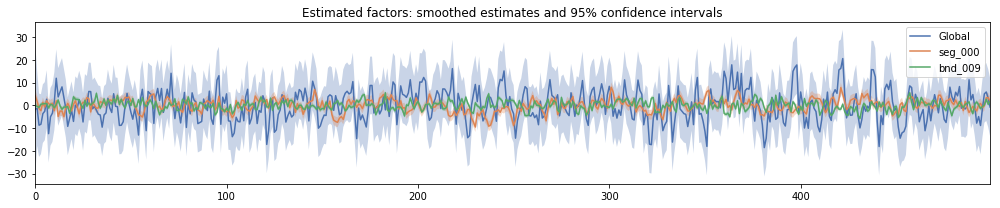

In [13]:
# Get estimates of the global and labor market factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global', 'seg_000','bnd_009']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
std = pd.concat([results.factors.smoothed_cov.loc[name, name]
                 for name in factor_names], axis=1)
crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

In [14]:
rsquared = results.get_coefficients_of_determination(method='individual')
rsquared
rsquared.columns

C:\Users\jshi2\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Global,bnd_000,bnd_001,bnd_002,bnd_003,bnd_004,bnd_005,bnd_006,bnd_007,bnd_008,...,seg_005,seg_006,seg_007,seg_008,seg_009,seg_010,seg_011,seg_012,seg_013,seg_014
y_0_0,0.288633,0.189411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_1,0.286859,NaN,0.243691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_2,0.326320,NaN,NaN,0.230589,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_3,0.321750,NaN,NaN,NaN,0.251262,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_4,0.258071,NaN,NaN,NaN,NaN,0.300189,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_5,0.340773,NaN,NaN,NaN,NaN,NaN,0.196601,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_6,0.296814,NaN,NaN,NaN,NaN,NaN,NaN,0.175700,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_7,0.363193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232415,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_8,0.319866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.267539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y_0_9,0.243455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Global', 'bnd_000', 'bnd_001', 'bnd_002', 'bnd_003', 'bnd_004',
       'bnd_005', 'bnd_006', 'bnd_007', 'bnd_008', 'bnd_009', 'bnd_010',
       'bnd_011', 'bnd_012', 'bnd_013', 'bnd_014', 'seg_000', 'seg_001',
       'seg_002', 'seg_003', 'seg_004', 'seg_005', 'seg_006', 'seg_007',
       'seg_008', 'seg_009', 'seg_010', 'seg_011', 'seg_012', 'seg_013',
       'seg_014'],
      dtype='object')

In [15]:
top_ten = []
for factor_name in rsquared.columns[:]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:5].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global        \
                               Variable $R^2$   
0                                y_6_12  0.40   
1                                y_0_12  0.39   
2                                y_0_10  0.39   
3                                y_0_13  0.38   
4                                y_1_12  0.37   

  Top ten variables explained by bnd_000        \
                                Variable $R^2$   
0                                 y_13_0  0.30   
1                                 y_12_0  0.30   
2                                 y_14_0  0.30   
3                                  y_4_0  0.28   
4                                  y_9_0  0.28   

  Top ten variables explained by bnd_001        \
                                Variable $R^2$   
0                                 y_10_1  0.28   
1                                  y_1_1  0.25   
2                                  y_8_1  0.25   
3                                 y_14_1  0.25   
4                                  y_0_1  0.24   

  Top ten variables explained by bnd_002        \
                                Variable $R^2$   
0                                  y_2_2  0.27   
1                                  y_7_2  0.26   
2                                 y_13_2  0.25   
3                                  y_5_2  0.25   
4                                  y_1_2  0.25   

  Top ten variables explained by bnd_003        ...  \
                                Variable $R^2$  ...   
0                                  y_1_3  0.37  ...   
1                                  y_8_3  0.32  ...   
2                                 y_10_3  0.29  ...   
3                                 y_12_3  0.28  ...   
4                                 y_14_3  0.27  ...   

  Top ten variables explained by seg_010        \
                                Variable $R^2$   
0                                 y_10_0  0.44   
1                                 y_10_6  0.43   
2                                 y_10_5  0.42   
3                                 y_10_4  0.41   
4                                y_10_14  0.38   

  Top ten variables explained by seg_011        \
                                Variable $R^2$   
0                                 y_11_4  0.49   
1                                 y_11_1  0.46   
2                                 y_11_8  0.46   
3                                 y_11_6  0.45   
4                                y_11_11  0.45   

  Top ten variables explained by seg_012        \
                                Variable $R^2$   
0                                 y_12_0  0.44   
1                                 y_12_5  0.41   
2                                 y_12_3  0.41   
3                                y_12_11  0.41   
4                                 y_12_9  0.40   

  Top ten variables explained by seg_013        \
                                Variable $R^2$   
0                                 y_13_9  0.40   
1                                 y_13_6  0.38   
2                                 y_13_4  0.38   
3                                 y_13_0  0.37   
4                                 y_13_3  0.36   

  Top ten variables explained by seg_014        
                                Variable $R^2$  
0                                 y_14_4  0.41  
1                                 y_14_6  0.40  
2                                 y_14_3  0.40  
3                                y_14_10  0.38  
4                                y_14_13  0.38  

[5 rows x 62 columns]

In [17]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

            500       501       502
y_0_0  0.335408  0.155574  0.053713
y_0_1  0.345114  0.283631  0.194080
y_0_2  0.531571  0.257102  0.092749
y_0_3 -0.295780  0.053591  0.141686
y_0_4 -0.408593 -0.146401 -0.079606


Text(500, -1.7, ' Forecast $\\rightarrow$')

[(-7.734475488075361, 8.811667685202051),
 Text(0.5, 1.0, 'simulation: in-sample predictions and out-of-sample forecasts, with 95% confidence intervals')]

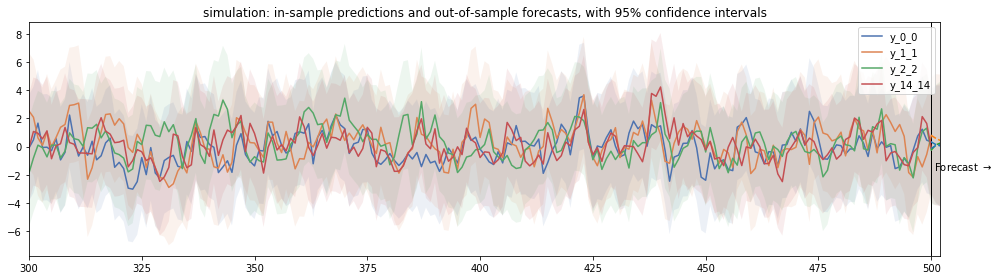

In [18]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start=300, end=502)

variables = ['y_0_0','y_1_1','y_2_2','y_14_14']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:500].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc[500:].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines(500, ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', (500, -1.7))
    ax.set(title=('simulation:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

Text(500, -1.7, ' Forecast $\\rightarrow$')

[(-8.521322633787946, 8.76141375778614),
 Text(0.5, 1.0, 'same segment:3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals')]

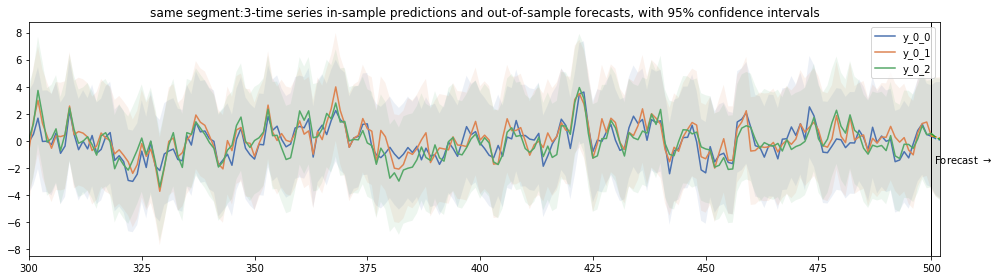

In [19]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start=300, end=502)

variables = ['y_0_0','y_0_1','y_0_2']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:500].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc[500:].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines(500, ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', (500, -1.7))
    ax.set(title=('same segment:'
                  '3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

Text(500, -1.7, ' Forecast $\\rightarrow$')

[(-8.415626725712132, 8.512131987748075),
 Text(0.5, 1.0, 'same bnd/sub:3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals')]

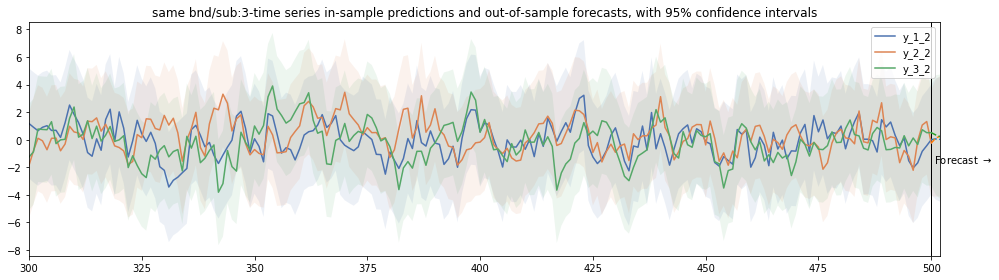

In [20]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start=300, end=502)

variables = ['y_1_2','y_2_2','y_3_2']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:500].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc[500:].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines(500, ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', (500, -1.7))
    ax.set(title=('same bnd/sub:'
                  '3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

Text(500, -1.7, ' Forecast $\\rightarrow$')

[(-7.7206821929966765, 8.522008488549679),
 Text(0.5, 1.0, 'different both segment and bnd/sub:3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals')]

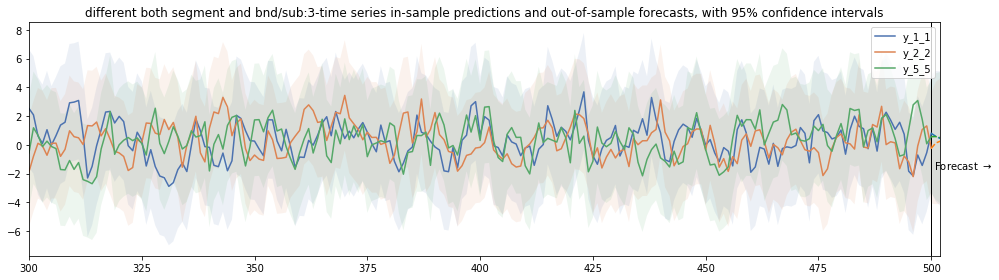

In [21]:
# Create forecasts results objects, through the end of 20201
prediction_results = results.get_prediction(start=300, end=502)

variables = ['y_1_1','y_2_2','y_5_5']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:500].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc[500:].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines(500, ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', (500, -1.7))
    ax.set(title=('different both segment and bnd/sub:'
                  '3-time series in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()